In [1]:
%%capture
!git clone https://github.com/matiasdperez/MEC_tesis.git

In [2]:
import os
os.chdir('MEC_tesis/')

# ARIMA Process

Esta notebook presenta el segundo experimento controlado en donde se compara la capacidad predictiva de las redes neuronales recurrentes con unidades LSTM frente a modelos econométricos tradicionales.

A continuación se simularán 1000 observaciones -inicializadas en 0- de dos series de tiempo las cuales siguen respectivos modelos ARIMA.



1.   ARMA(2,0,2): $y_t = 0.001t + 0.6y_{t-1} + 0.3y_{t-2}+ ε_{t} + 0.2ε_{t-1}+0.1ε_{t-2} \;/\; ε_{i}∼N(0,1)$
2.   ARIMA(3,1,2): $Δy_t = 0.5Δy_{t-1} + 0.2Δy_{t-2} + 0.1Δy_{t-3} + ε_t + 0.3ε_{t-1}+0.1ε_{t-2}\;/ε_i ∼ N(0,1)$

Para cada uno de ellos, se divide la serie temporal simulada en train (primer 75% de la muestra) y test (restante 25%). Es en este subconjunto en donde se evalúa y compara la capacidad predictiva de los mismos 5 modelos propuestos en el experimento 1. De igual manera, se aplica un cambio de parámetros discrecional sobre ambos DGP en en timestep $t=750$: la tarea de los modelos será predecir de la manera más precisa estas nuevas observaciones aún cuando no han sido entrenados con ese DGP.


-------
_______

In [3]:
%load_ext autoreload
%autoreload 2

## 1) Setup

In [4]:
%%capture
! pip install dieboldmariano pmdarima keras-tuner tensorflow-addons

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
import tqdm as tqdm
import random
from sklearn.preprocessing import StandardScaler
from dieboldmariano import dm_test

pd.set_option('max_colwidth', 400)
warnings.filterwarnings("ignore")

np.random.seed(42)

from utils.simulators import ARIMA
from utils.statistical_models import *
from utils.NN_models import *

## 2) Simulación

Se instancian 2 objetos de la clase ARIMA y se simulan 1,000 timesteps bajo las especificaciones ya mencionadas y tomando como valor inicial 0:

In [6]:
n_steps = 1000
random_seed = 42

In [7]:
arma = ARIMA(n_steps=n_steps,
            ARIMA_model=[2,0,2],
            AR_params=[0.6, 0.3],
            MA_params=[0.2, 0.1],
            random_seed=random_seed,
            **{'constant':0, 'trend':0.001, 'sigma_y':1})
arma.simulate()

arima = ARIMA(n_steps=n_steps,
            ARIMA_model=[3,1,2],
            AR_params=[0.5, 0.2, 0.1],
            MA_params=[0.3, 0.1],
            random_seed=random_seed,
            **{'constant':0, 'trend':0, 'sigma_y':1})
arima.simulate()

Simulating: 1000it [00:00, 16995.25it/s]           
Simulating: 1000it [00:00, 20468.81it/s]           


De las 1,000 observaciones simuladas, las primeras 750 constituyen el dataset de entrenamiento y las segundas 250, el de test.

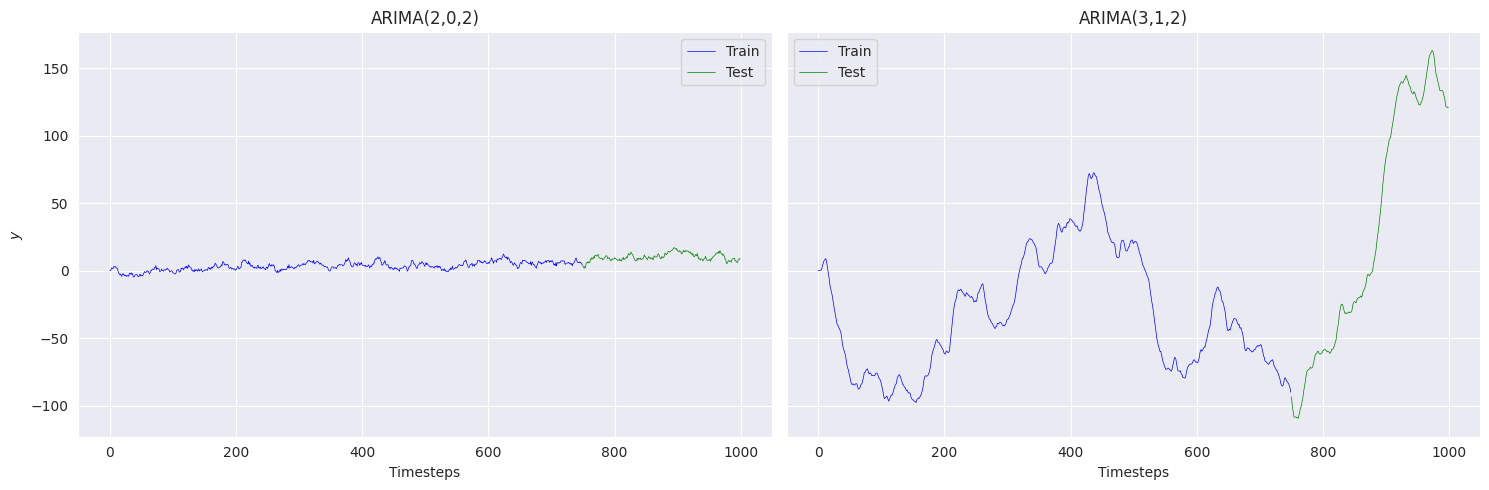

In [8]:
split_index = int(len(arima.y) * 0.75)

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.lineplot(x=range(split_index), y=arma.y[:split_index], ax=axs[0], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(arma.y)), y=arma.y[split_index:], ax=axs[0], lw=0.5, color='green', label='Test')
axs[0].set_title("ARIMA(2,0,2)")
axs[0].set_xlabel("Timesteps")
axs[0].set_ylabel("$y$")

sns.lineplot(x=range(split_index), y=arima.y[:split_index], ax=axs[1], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(arima.y)), y=arima.y[split_index:], ax=axs[1], lw=0.5, color='green', label='Test')
axs[1].set_title("ARIMA(3,1,2)")
axs[1].set_xlabel("Timesteps")

plt.legend(loc='upper left')
plt.tight_layout();


A continuación se presentan las funciones de autocorrelación y autocorrelación parcial para los dos modelos. En ambos casos se observa evidencia de la presencia de raíz unitaria en los procesos: un ACF empírica que decrece muy lentamente y una PACF en la que solo es estadísticamente significativo el primer lag.

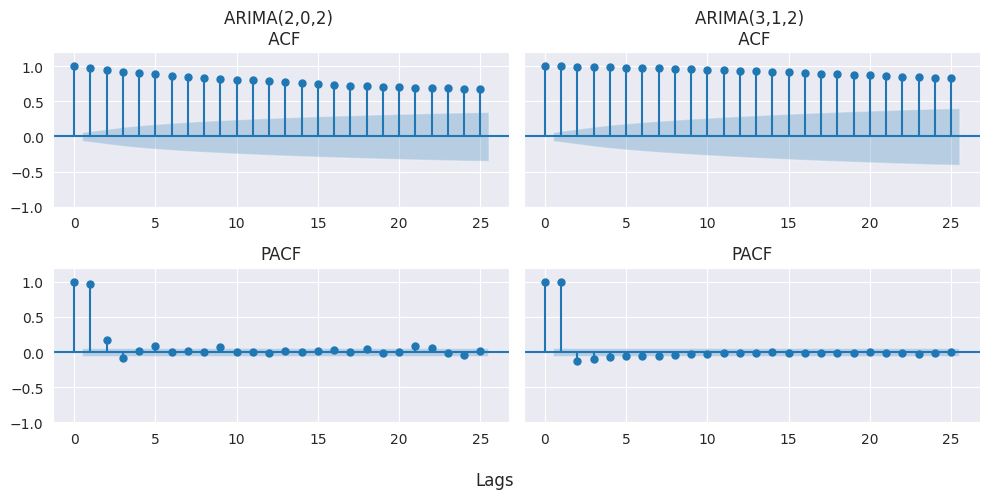

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

plot_acf(arma.y, lags=25, ax=axs[0,0])
plot_pacf(arma.y, lags=25, ax=axs[1,0])
axs[0,0].set_title("ARIMA(2,0,2) \n ACF")
axs[0,0].set_ylim([-1, 1.2])
axs[1,0].set_title("PACF")

plot_acf(arima.y, lags=25, ax=axs[0,1])
plot_pacf(arima.y, lags=25, ax=axs[1,1])
axs[0,1].set_title("ARIMA(3,1,2) \n ACF")
axs[0,1].set_ylim([-1, 1.2])
axs[1,1].set_title("PACF")

fig.supxlabel('Lags')
plt.tight_layout()
plt.show()

A continuación se realiza el split en train-test para cada uno de los DGP simulados. Se toman el primer 75% de las observaciones para train (750 observaciones) y el restante 25% para test (250 observaciones).

In [10]:
arma_y_train, arma_y_test = arma.y[:split_index], arma.y[split_index:]
arima_y_train, arima_y_test = arima.y[:split_index], arima.y[split_index:]

## 3) Cross-validation de hiperparámetros

En esta fase del workflow de trabajo, se utiliza el conjunto de entrenamiento y validación para buscar el set de hiperparámetros que mejor ajusta la forma funcional del modelo al problema concreto (i.e, aquel modelo que minimiza el error cuadrático medio sobre el conjunto de validación). Los espacios de hiperparámetros definidos para cada modelo son los siguientes:

1) <ins> Modelo ARIMA </ins>: se buscarán de manera automática la tupla (p,I,q), esto es, el orden del término autorregresivo AR, el orden de integración y el órden del término de medias móviles MA dentro de un espacio de hiperparámetros dado por el producto cartesiano especificado por el usuario. Por ejemplo: {0,1,2,3}x{0,1,2}x{0,1,2,3}.
A su vez, para el caso del modelo ARIMA, se utilizan 2 estrategias de cross-validation:

    * Rolling window
    * Sliding window

2) <ins> Modelo ETS </ins>: en el caso del modelo ETS, se buscarán de manera automática sobre un espacio de hiperparámetros que definen la forma funcional de las ecuaciones que rigen el modelo. El mismo se define como el producto cartesiano de los siguientes conjuntos:

    * error_type = {aditivo, multiplicativo}
    * trend_type = {sin_tendencia, aditiva, multiplicativa}
    * dampend_trend = {Verdado, Falso}
    * seasonal_component = {}

    Al igual que para el caso del modelo ARIMA, se utilizan las dos mismas estrategias de cross-validation.

3) <ins> Stacked LSTM </ins>: para el caso de las redes neuronales, se define una arquitectura general dado por el tipo de unidades o neuronas (en este caso, vanilla LSTM) y un espacio de hiperprámetros "grande", el cual no es explorado de manera exhaustiva sino que se escogen una serie de configuraciones de manera aleatoria y se recupera aquella configuración que minimiza la función de pérdida sobre el conjunto de validación (partición del conjunto de entrenamiento original). Una vez más, el espacio de hiperparámetros se construye como el cartesiano de los siguientes conjuntos:

    * Función de activación = {'relu', 'tanh', 'sigmoid', 'elu'} --> función de activación aplicadas a la cell state y al estado oculto de la red.
    * Unidades en la primera capa recurrente = {16, 32, 64, 128}
    * Incluir segunda capa LSTM = {True, False}
    * Unidades en la segunda capa recurrente (en caso de existir) = {16, 32, 64, 128}
    * Unidades en la capa densa = {16, 32, 64, 128} --> número de neuronas en la capa densa que transforma la salida vectorial de la red LSTM en el valor escalar a predecir.
    * Learning Rate = {1e-2, 1e-3, 1e-4} --> learning_rate utilizado por el optimizador en la búsqueda de los parámetros del modelo.
    * Optimizador = {'adam', 'sgd', 'rmsprop'}
    * Dropout rate = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> tasa de dropout, utilizada para eliminar conexiones entre neuronas de manera aleatoria durante la fase de entrenamientod de la red y así evitar overfitting
    * Inicializadores = {'random_normal','glorot_uniform', 'he_normal'} --> distribuciones de las que se samplean los valores iniciales de los pesos y biases de la red, y le da naturaleza estocástica al entrenamiento de la NN.
    * Coeficiente L2 = {0, 0.1, 0.2, 0.3, 0.4, 0.5} --> penalización utilizada para evitar que los pesos de la red "crezcan" demasiado y overfitteen la red (aka. weight decay).

4) <ins> LSTM con Peepholes </ins>: mismo espacio de búsqueda de hiperparámetros que el modelo *Stacked LSTM*

5) <ins> Encoder-Decoder LSTM </ins>: la única diferencia en el espacio de hiperparámetros frente a las otras arquitecturas es que en este modelo, en caso de existir una segunda capa oculta, se la fuerza a que tenga una dimensión menor al número de unidades de la primera capa oculta para lograr así la forma de "embudo" típico de las redes neuronales encoder-decoder.


### 3.1) ARIMA model

In [11]:
# Definición del espacio de hiperparámetros sobre el cual buscar la mejor configuración del modelo para el problema

AR_order = [0,1,2,3]
MA_order = [0,1,2,3]
I_order = [0,1,2]

# Dado que el espacio de búsqueda de hiperparámetros tiene una cardinalidad muy alta para realizar una búsqueda exhaustiva, se opta en su lugar
# por tomar una muestra de 30 combinaciones de hiperparámetros del espacio de búsqueda.

random.seed(1234)
search_space = random.sample(list(product(AR_order, I_order, MA_order)), 30)

A modo de ejemplo, se procede a cross-validar el modelo con el search_space recien construido y bajo las siguientes especificaciones:
* `h = 1`
* `stride = 25`
* `window_length = 50`
* `evaluation_metric = mean_squared_error`

El número de folds se determina de manera automática en base a la combinación de `h`, `stride` y `window_length`.

In [12]:
arima_vanilla = ArimaModel(arma_y_train, arma_y_test, **{'with_intercept':False})

In [13]:
arima_vanilla.cross_validate(ARIMA_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

100%|██████████| 30/30 [06:46<00:00, 13.54s/it]


A continuación se muestra el top 10 configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [14]:
arima_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,AR_order,I_order,MA_order,rolling_median_MSE,sliding_median_MSE
3,0,1,1,0.640449,0.538870
22,1,1,0,0.668456,0.570903
1,0,1,3,0.640994,0.659240
27,1,1,1,0.717459,0.680406
26,1,2,1,0.704855,0.683232
14,2,1,2,0.733080,0.712912
18,3,1,1,0.515422,0.716152
0,2,1,0,0.759696,0.716547
23,3,0,2,0.515554,0.724792
9,1,0,3,0.408844,0.739923


In [15]:
print(f"La mejor configuración para la estrategia de sliding window es: {arima_vanilla.best_model('sliding')}")

La mejor configuración para la estrategia de sliding window es: (0, 1, 1)


Se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,I,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [16]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [25, 50, 100]

#### 3.1.1) ARMA(2,0,2)

In [17]:
arma_arima_results = defaultdict(defaultdict)
arima_best_models = defaultdict((lambda: defaultdict(dict))) #En este diccionario se guardará el mejor modelo para cada DGP y combinación de h, stride y window_length

In [19]:
%%time
for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = ArimaModel(arma_y_train, arma_y_test, **{'with_intercept':False, 'method':'nm'})
        model.cross_validate(ARIMA_configs=search_space,
                                                       h = h,
                                                       stride=s,
                                                       window_length=l,
                                                       eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        arma_arima_results[h][(s, l)] = {
            'best_model': model.best_model('sliding'),
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arma'][h]['arima'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 30/30 [03:00<00:00,  6.01s/it]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 30/30 [02:52<00:00,  5.76s/it]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 30/30 [02:57<00:00,  5.92s/it]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 30/30 [02:41<00:00,  5.40s/it]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 30/30 [02:50<00:00,  5.70s/it]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 30/30 [02:57<00:00,  5.93s/it]


Cross-validation model with h=14, stride=25, window_length=25: 



100%|██████████| 30/30 [02:44<00:00,  5.49s/it]


Cross-validation model with h=14, stride=25, window_length=50: 



100%|██████████| 30/30 [02:48<00:00,  5.63s/it]


Cross-validation model with h=14, stride=25, window_length=100: 



100%|██████████| 30/30 [02:58<00:00,  5.94s/it]

CPU times: user 23min 37s, sys: 19min 5s, total: 42min 43s
Wall time: 25min 53s


En la siguiente tabla, se observan los resultados de cross-validar de manera conjunta window_length y los parámetros del modelo ARIMA dado un hizonte de forecasting `h` y un `stride` de 25 timesteps. Se observa como para el caso de $h=1$, la validación automática de hiperparámetros escoge una configuración distinta a la que le dió origen: en lugar de un modelo ARMA(2,0,2), la configuración que minimiza el MSE es ARIMA(0,1,1) con un `window_length = 25`. Lo mismo ocurre para $h=7$: la configuración elegida es ARIMA(3,1,2).

Al igual que para el experimento 1, los modelos tienden a complejizarse en la medida que el horizonte temporal a forecastear es más largo.

In [20]:
arma_arima_cv = pd.DataFrame([(k1, k2[0], k2[1], v['best_model'][0], v['best_model'][1], v['best_model'][2], v['best_MSE'])
                                for k1, v1 in arma_arima_results.items()
                                for k2, v in v1.items()],
                                columns=['h', 'stride', 'window_length', 'AR_order', 'I_order', 'MA_order', 'Best_MSE'])
arma_arima_cv

,h,stride,window_length,AR_order,I_order,MA_order,Best_MSE
0,1,25,25,0,1,1,0.591790
1,1,25,50,0,1,1,0.538866
2,1,25,100,3,1,2,0.643959
3,7,25,25,3,1,2,2.486704
4,7,25,50,3,1,3,2.585962
5,7,25,100,2,1,2,2.590396
6,14,25,25,2,1,2,3.434617
7,14,25,50,0,1,3,3.333945
8,14,25,100,3,1,3,3.406719


Se repite este mismo procedimiento para el DGP `ARIMA(3,1,2)`

#### 3.1.2) ARIMA(3,1,2)

In [21]:
arima_arima_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        try:
            print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
            model = ArimaModel(arima_y_train, arima_y_test, **{'with_intercept':False, 'method':'nm'})
            model.cross_validate(ARIMA_configs=search_space,
                                                        h = h,
                                                        stride=s,
                                                        window_length=l,
                                                        eval_metric='mean_squared_error')
            MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
            arima_arima_results[h][(s, l)] = {
                'best_model': model.best_model('sliding'),
                'best_MSE': MSE
            }
            if MSE < best_MSE:
                best_MSE = MSE
                arima_best_models['arima'][h]['arima'] = model
        except:
            pass

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 30/30 [02:39<00:00,  5.32s/it]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 30/30 [02:40<00:00,  5.35s/it]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 30/30 [02:50<00:00,  5.67s/it]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 30/30 [02:35<00:00,  5.19s/it]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 30/30 [02:38<00:00,  5.29s/it]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 30/30 [02:41<00:00,  5.39s/it]


Cross-validation model with h=14, stride=25, window_length=25: 



100%|██████████| 30/30 [02:34<00:00,  5.16s/it]


Cross-validation model with h=14, stride=25, window_length=50: 



100%|██████████| 30/30 [02:36<00:00,  5.22s/it]


Cross-validation model with h=14, stride=25, window_length=100: 



100%|██████████| 30/30 [02:46<00:00,  5.55s/it]


In [22]:
arima_arima_cv = pd.DataFrame([(k1, k2[0], k2[1], v['best_model'][0], v['best_model'][1], v['best_model'][2], v['best_MSE'])
                                for k1, v1 in arima_arima_results.items()
                                for k2, v in v1.items()],
                                columns=['h', 'stride', 'window_length', 'AR_order', 'I_order', 'MA_order', 'Best_MSE'])
arima_arima_cv

,h,stride,window_length,AR_order,I_order,MA_order,Best_MSE
0,1,25,25,1,1,1,0.563986
1,1,25,50,0,1,1,0.465113
2,1,25,100,0,1,1,0.399117
3,7,25,25,1,1,0,13.779366
4,7,25,50,1,1,0,12.699246
5,7,25,100,2,1,2,8.392461
6,14,25,25,2,1,2,46.982158
7,14,25,50,2,1,2,33.310789
8,14,25,100,1,1,1,41.872959


Para el caso ARIMA(3,1,2), se cumple que la validación cruzada termina escogiendo `window_lengths` más largos que para el modelo más simple ARMA(2,0,2), así como modelos más complejos en la medida que $h$ es más lejano en el tiempo.

### 3.2) ETS Model

In [23]:
# Definición del espacio de búsqueda de hiperparámetros para el modelo ETS

config = {
    'error' : ['add','mul'],
    'trend' : ['add','mul', None],
    'damped_trend' : [True, False],
    'seasonal' : [None]
}

# Dado que el espacio de búsqueda tiene baja cardinalidad, a diferencia del modelo ARIMA, se opta por una búsqueda exhaustiva de hiperparámetros

search_space = [dict(zip(config.keys(), x)) for x in product(*config.values())]

In [24]:
ets_vanilla = EtsModel(arma_y_train, arma_y_test)

In [25]:
ets_vanilla.cross_validate(ETS_configs=search_space,
                              h = 1,
                              stride=25,
                              window_length=50,
                              eval_metric='mean_squared_error')

100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


A continuación se muestra el top configuraciones de hiperparámetros, ordenados por la mediana del error cuadrático en cada fold para la estrategia `sliding_window`.

In [26]:
ets_vanilla.cross_validation_df.sort_values('sliding_median_MSE').head(10)

,index,rolling_median_MSE,sliding_median_MSE
2,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.64016,0.53714
1,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",0.66722,0.71721
0,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.63871,0.77347


In [27]:
print(f"La mejor configuración para la estrategia de sliding window es: {ets_vanilla.best_model('sliding')['index']}")

La mejor configuración para la estrategia de sliding window es: {'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}


A continuación, se generaliza la búsqueda del 'mejor conjunto' de hiperparámetros (p,I,q) para cada modelo, variando el horizonte de predicción `h` y utilizando distintos valores de `window_length` y un `stride` fijo de 25. En todos los casos se utiliza una estrategia de cross-validation de tipo `sliding_window` (de la interacción con el hiperparámetro `stride` surgirá si los folds se solapan o no) y la métrica a evaluar sobre el conjunto de validación es MSE.

In [28]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [25, 50, 100]

#### 3.2.1) ARMA(2,0,2)

In [29]:
arma_ets_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = EtsModel(arma_y_train, arma_y_test)
        model.cross_validate(ETS_configs=search_space,
                            h = h,
                            stride=s,
                            window_length=l,
                            eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        arma_ets_results[h][(s, l)] = {
            'best_model': model.best_model('sliding')['index'],
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arma'][h]['ets'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 12/12 [00:03<00:00,  3.82it/s]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 12/12 [00:03<00:00,  3.80it/s]


Cross-validation model with h=14, stride=25, window_length=25: 



100%|██████████| 12/12 [00:04<00:00,  2.46it/s]


Cross-validation model with h=14, stride=25, window_length=50: 



100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


Cross-validation model with h=14, stride=25, window_length=100: 



100%|██████████| 12/12 [00:03<00:00,  3.83it/s]


In [30]:
data = []

for key1, value1 in arma_ets_results.items():
    for key2, value2 in value1.items():
        row = value2.copy()
        row['h'] = key1
        row['stride'], row['window_length'] = key2
        data.append(row)

columns = ['h', 'stride', 'window_length', 'best_model', 'best_MSE']
arma_ets_cv = pd.DataFrame(data, columns=columns)

arma_ets_cv

,h,stride,window_length,best_model,best_MSE
0,1,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.31591
1,1,25,50,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.53714
2,1,25,100,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",0.65021
3,7,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",1.42038
4,7,25,50,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",1.55631
5,7,25,100,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",1.50369
6,14,25,25,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",2.80784
7,14,25,50,"{'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': None}",2.79513
8,14,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",2.72608


La validación cruzada de hiperparámetros arroja que para el caso del modelo ETS en el DGP ARMA(2,0,2), el `window_length` óptimo es 25 para ambos $h$. Llama la atención que la configuración óptima se simplifica para horizontes de tiempo más largo: de incluir `trend` y `dampened_trend` a no hacerlo al pasar de $h=1$ a $h=7$.

#### 3.2.3) ARIMA(3,0,2)

In [31]:
arima_ets_results = defaultdict(defaultdict)

for h in h_list:
    best_MSE = 9999
    for s, l in list(product(strides_list, window_length_list)):
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = EtsModel(arima_y_train, arima_y_test)
        model.cross_validate(ETS_configs=search_space,
                            h = h,
                            stride=s,
                            window_length=l,
                            eval_metric='mean_squared_error')
        MSE = model.cross_validation_df.sort_values('sliding_median_MSE').reset_index()['sliding_median_MSE'][0]
        arima_ets_results[h][(s, l)] = {
            'best_model': model.best_model('sliding')['index'],
            'best_MSE': MSE
        }
        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arima'][h]['ets'] = model

Cross-validation model with h=1, stride=25, window_length=25: 



100%|██████████| 12/12 [00:02<00:00,  4.11it/s]


Cross-validation model with h=1, stride=25, window_length=50: 



100%|██████████| 12/12 [00:03<00:00,  3.39it/s]


Cross-validation model with h=1, stride=25, window_length=100: 



100%|██████████| 12/12 [00:03<00:00,  3.84it/s]


Cross-validation model with h=7, stride=25, window_length=25: 



100%|██████████| 12/12 [00:02<00:00,  4.09it/s]


Cross-validation model with h=7, stride=25, window_length=50: 



100%|██████████| 12/12 [00:02<00:00,  4.30it/s]


Cross-validation model with h=7, stride=25, window_length=100: 



100%|██████████| 12/12 [00:02<00:00,  4.66it/s]


Cross-validation model with h=14, stride=25, window_length=25: 



100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Cross-validation model with h=14, stride=25, window_length=50: 



100%|██████████| 12/12 [00:02<00:00,  4.28it/s]


Cross-validation model with h=14, stride=25, window_length=100: 



100%|██████████| 12/12 [00:02<00:00,  4.57it/s]


In [32]:
data = []

for key1, value1 in arima_ets_results.items():
    for key2, value2 in value1.items():
        row = value2.copy()
        row['h'] = key1
        row['stride'], row['window_length'] = key2
        data.append(row)

columns = ['h', 'stride', 'window_length', 'best_model', 'best_MSE']
drift_trend_rw_ets_cv = pd.DataFrame(data, columns=columns)

drift_trend_rw_ets_cv

,h,stride,window_length,best_model,best_MSE
0,1,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.60524
1,1,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.65077
2,1,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",0.77158
3,7,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",8.85226
4,7,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",6.56818
5,7,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': True, 'seasonal': None}",7.09590
6,14,25,25,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",27.83005
7,14,25,50,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",24.16890
8,14,25,100,"{'error': 'add', 'trend': 'add', 'damped_trend': False, 'seasonal': None}",27.73464


A diferencia del caso ARMA(2,0,2), la configuraciones óptimas para el modelo ARIMA(3,1,2) son exactamente las mismas para $h=1$ y $h=7$, la única diferencia es que se amplía la `window_length` con la que se debe entrenar el modelo.

### 3.3) Stacked LSTM

In [33]:
# El entrenamiento de redes neuronales suele ser más estable si se normalizan los datos de entrada. Por lo tanto, se normalizan los datos de entrenamiento y test de cada DGP simulado.

scaler_arma = StandardScaler()

arma_y_train_scaled = scaler_arma.fit_transform(arma_y_train.reshape(-1, 1))
arma_y_test_scaled = scaler_arma.transform(arma_y_test.reshape(-1, 1))

In [34]:
LSTM_model = LSTMnetwork(train=arma_y_train_scaled,
                         test=arma_y_test_scaled,
                         seq_length=25, h=1, batch_size=64, stride=25)

In [35]:
LSTM_model.cross_validate(DGP='example_arma')

Trial 10 Complete [00h 00m 26s]
val_loss: 4.5442860921223955

Best val_loss So Far: 0.2857036590576172
Total elapsed time: 00h 03m 27s


In [36]:
LSTM_model.tuner.get_best_hyperparameters()[0].values

{'activation': 'tanh',
 'recurrent_layer_1': 128,
 'recurrent_layer_2': 64,
 'dense_layer_1': 128,
 'learning_rate': 0.001,
 'optimizer': 'adam',
 'drop_out_rate': 0.1,
 'initializer': 'glorot_uniform',
 'l2_coeff': 0.0,
 'with_second_hidden_layer': True}

### 3.3.1) ARMA(2,0,2)

A diferencia de los modelos ARIMA y ETS en donde, dado `h` y fijado el `stride=25`, se *cross-validaban* conjuntamente el `window_length` y los hiperpámetros propios del modelo, en el caso de las NN se le agrega un hiperparámetro adicional: el `batch_size`, es decir, el número de secuencias que son procesadas de manera conjunta para obtener el gradiente y propagarlo hacia atrás en la red.

In [40]:
h_list = [1, 7]
strides_list = [25]
window_length_list = [2, 5, 25, 50, 100]
batch_size = [32, 64, 128]

# Dado el costo computacional de cross-validar una red neuronal, se opta por elegir aleatoriamente 5 combinaciones de
# window_length y batch_size para cross-validar

os.chdir('notebooks/simulaciones')

random.seed(42)
search_space = product(strides_list, random.sample(list(product(window_length_list, batch_size)), 5))
search_space = [[i[0], i[1][0], i[1][1]] for i in search_space]

In [41]:
arma_stacked_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = LSTMnetwork(train=arma_y_train_scaled,
                            test=arma_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arma',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arma_stacked_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arma'][h]['stacked_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/arma_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/arma_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/arma_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/arma_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/LSTM/arma_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/arma_LSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/arma_LSTM_2_seq_7_h_64

In [42]:
flattened_data = []
for outer_key, inner_dict in arma_stacked_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arma_lstm_cv = pd.DataFrame(flattened_data)

arma_lstm_cv[['stride', 'length', 'batch_size']] = arma_lstm_cv['config'].apply(lambda x: pd.Series(x))
arma_lstm_cv = arma_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arma_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arma_lstm_cv = arma_lstm_cv.reindex(columns=column_order)

arma_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.290258
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.259202
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,1.128756
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.186058
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.054873
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.623846
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.660512
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.478799
8,7,25,50,128,sigmoid,32,32,32,0.0010,rmsprop,0.2,random_normal,0.0,False,0.606250
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.480129


### 3.3.2) ARIMA(3,1,2)

In [43]:
scaler_arima_trend = StandardScaler()

arima_y_train_scaled = scaler_arima_trend.fit_transform(arima_y_train.reshape(-1, 1))
arima_y_test_scaled = scaler_arima_trend.transform(arima_y_test.reshape(-1, 1))

In [44]:
arima_stacked_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = LSTMnetwork(train=arima_y_train_scaled,
                            test=arima_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arima',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arima_stacked_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arima'][h]['stacked_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/arima_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/arima_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/arima_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/arima_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/LSTM/arima_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/LSTM/arima_LSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner from tuner/LSTM/arima_LSTM_2_seq

In [45]:
flattened_data = []
for outer_key, inner_dict in arima_stacked_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arima_lstm_cv = pd.DataFrame(flattened_data)

arima_lstm_cv[['stride', 'length', 'batch_size']] = arima_lstm_cv['config'].apply(lambda x: pd.Series(x))
arima_lstm_cv = arima_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arima_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arima_lstm_cv = arima_lstm_cv.reindex(columns=column_order)

arima_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.155649
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.099054
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,0.553804
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.051101
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.560577
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.162551
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.117555
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.077724
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.576359
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.075119


### 3.4) Stacked LSTM con Peepholes

#### 3.4.1) Vanilla RW

In [46]:
arma_peephole_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = PeepholedLSTMnetwork(train=arma_y_train_scaled,
                            test=arma_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arma',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arma_peephole_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arma'][h]['peephole_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arma_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation mod

In [47]:
flattened_data = []
for outer_key, inner_dict in arma_peephole_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arma_peephole_lstm_cv = pd.DataFrame(flattened_data)

arma_peephole_lstm_cv[['stride', 'length', 'batch_size']] = arma_peephole_lstm_cv['config'].apply(lambda x: pd.Series(x))
arma_peephole_lstm_cv = arma_peephole_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arma_peephole_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arma_peephole_lstm_cv = arma_peephole_lstm_cv.reindex(columns=column_order)

arma_peephole_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.666541
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.348944
2,1,25,2,32,tanh,32,16,16,0.0001,rmsprop,0.4,random_normal,0.0,False,1.222793
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.812295
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.933156
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.617405
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.848685
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.592147
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.990898
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.728713


#### 3.4.2) ARIMA(3,1,2)

In [49]:
arima_peephole_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = PeepholedLSTMnetwork(train=arima_y_train_scaled,
                            test=arima_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arima',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arima_peephole_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arima'][h]['peephole_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

tensorflow_addons is already installed.
Reloading Tuner from tuner/PeepholedLSTM/arima_LSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validatio

In [50]:
flattened_data = []
for outer_key, inner_dict in arima_peephole_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arima_peephole_lstm_cv = pd.DataFrame(flattened_data)

arima_peephole_lstm_cv[['stride', 'length', 'batch_size']] = arima_peephole_lstm_cv['config'].apply(lambda x: pd.Series(x))
arima_peephole_lstm_cv = arima_peephole_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arima_peephole_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arima_peephole_lstm_cv = arima_peephole_lstm_cv.reindex(columns=column_order)

arima_peephole_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,dense_layer_1,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,tanh,128,64,128,0.0010,adam,0.1,glorot_uniform,0.0,True,0.505254
1,1,25,2,64,relu,16,128,128,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.131983
2,1,25,2,32,elu,32,32,128,0.0001,adam,0.1,glorot_uniform,0.0,False,0.586782
3,1,25,50,128,elu,64,16,16,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.414398
4,1,25,5,64,sigmoid,16,16,32,0.0001,rmsprop,0.2,random_normal,0.1,True,1.503100
5,7,25,50,64,tanh,64,16,32,0.0100,rmsprop,0.3,he_normal,0.0,True,0.916861
6,7,25,2,64,relu,16,128,64,0.0010,rmsprop,0.2,he_normal,0.0,True,0.352211
7,7,25,2,32,elu,64,16,64,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.163264
8,7,25,50,128,relu,64,16,128,0.0001,rmsprop,0.3,random_normal,0.0,False,0.584967
9,7,25,5,64,sigmoid,16,32,64,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.202993


### 3.5) Encoder-Decoder LSTM

#### 3.5.1) ARMA(2,0,2)

In [51]:
arma_s2s_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = Seq2SeqLSTM(train=arma_y_train_scaled,
                            test=arma_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arma',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arma_s2s_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arma'][h]['s2s_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arma_S2SLSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tuner fr

In [52]:
flattened_data = []
for outer_key, inner_dict in arma_s2s_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arma_s2s_lstm_cv = pd.DataFrame(flattened_data)

arma_s2s_lstm_cv[['stride', 'length', 'batch_size']] = arma_s2s_lstm_cv['config'].apply(lambda x: pd.Series(x))
arma_s2s_lstm_cv = arma_s2s_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arma_s2s_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arma_s2s_lstm_cv = arma_s2s_lstm_cv.reindex(columns=column_order)

arma_s2s_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,sigmoid,16,0.250,0.0100,rmsprop,0.1,glorot_uniform,0.0,False,0.591428
1,1,25,2,64,sigmoid,16,0.500,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,1.077869
2,1,25,2,32,tanh,64,0.500,0.0010,rmsprop,0.0,he_normal,0.0,False,0.128660
3,1,25,50,128,relu,16,0.250,0.0001,sgd,0.3,glorot_uniform,0.0,False,0.901613
4,1,25,5,64,relu,32,0.125,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.742322
5,7,25,50,64,tanh,16,0.500,0.0001,rmsprop,0.4,random_normal,0.0,False,1.187686
6,7,25,2,64,tanh,32,0.125,0.0001,adam,0.1,glorot_uniform,0.0,False,0.996059
7,7,25,2,32,sigmoid,32,0.250,0.0010,sgd,0.3,glorot_uniform,0.0,False,0.874182
8,7,25,50,128,tanh,32,0.250,0.0010,rmsprop,0.2,random_normal,0.0,False,0.905686
9,7,25,5,64,relu,128,0.125,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.600798


#### 3.5.2) ARIMA(3,1,2)

In [53]:
arima_s2s_lstm_results = defaultdict(defaultdict)

seed = 42

for h in h_list:
    best_MSE = 9999
    for s, l, b in search_space:
        print(f'Cross-validation model with h={h}, stride={s}, window_length={l}: \n')
        model = Seq2SeqLSTM(train=arima_y_train_scaled,
                            test=arima_y_test_scaled,
                            seq_length=l,
                            h=h,
                            batch_size=b,
                            stride=s)

        model.cross_validate(DGP = f'arima',
                            **{'seed':seed, 'epochs':5})

        MSE = model.tuner.oracle.get_best_trials(num_trials=1)[0].metrics.get_best_value('val_loss')

        arima_s2s_lstm_results[h][(s, l, b)] = {
            'best_model': model.tuner.get_best_hyperparameters()[0].values,
            'best_MSE': MSE
        }

        if MSE < best_MSE:
            best_MSE = MSE
            arima_best_models['arima'][h]['s2s_lstm'] = model

        seed += 1

Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_50_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_2_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=2: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_2_seq_1_h_32_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_50_seq_1_h_128_batch_25_stride/tuner0.json
Cross-validation model with h=1, stride=25, window_length=5: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_5_seq_1_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=50: 

Reloading Tuner from tuner/S2SLSTM/arima_S2SLSTM_50_seq_7_h_64_batch_25_stride/tuner0.json
Cross-validation model with h=7, stride=25, window_length=2: 

Reloading Tu

In [54]:
flattened_data = []
for outer_key, inner_dict in arima_s2s_lstm_results.items():
    for config, results in inner_dict.items():
        row = {
            'h': outer_key,
            'config': config,
            **results['best_model'],
            'best_MSE': results['best_MSE']
        }
        flattened_data.append(row)

arima_s2s_lstm_cv = pd.DataFrame(flattened_data)

arima_s2s_lstm_cv[['stride', 'length', 'batch_size']] = arima_s2s_lstm_cv['config'].apply(lambda x: pd.Series(x))
arima_s2s_lstm_cv = arima_s2s_lstm_cv.drop(columns=['config'])
column_order = ['h', 'stride', 'length', 'batch_size'] + \
    [col for col in arima_s2s_lstm_cv.columns if col not in ['h', 'stride', 'length', 'batch_size']]
arima_s2s_lstm_cv = arima_s2s_lstm_cv.reindex(columns=column_order)

arima_s2s_lstm_cv

,h,stride,length,batch_size,activation,recurrent_layer_1,recurrent_layer_2,learning_rate,optimizer,drop_out_rate,initializer,l2_coeff,with_second_hidden_layer,best_MSE
0,1,25,50,64,sigmoid,16,0.250,0.0100,rmsprop,0.1,glorot_uniform,0.0,False,0.465851
1,1,25,2,64,sigmoid,16,0.500,0.0100,rmsprop,0.4,glorot_uniform,0.0,False,0.528241
2,1,25,2,32,tanh,64,0.500,0.0010,rmsprop,0.0,he_normal,0.0,False,0.056694
3,1,25,50,128,relu,16,0.250,0.0001,sgd,0.3,glorot_uniform,0.0,False,0.565266
4,1,25,5,64,relu,32,0.125,0.0100,rmsprop,0.0,glorot_uniform,0.0,False,0.264178
5,7,25,50,64,tanh,16,0.500,0.0001,rmsprop,0.4,random_normal,0.0,False,0.621669
6,7,25,2,64,sigmoid,16,0.125,0.0100,sgd,0.0,random_normal,0.0,False,0.503656
7,7,25,2,32,sigmoid,32,0.250,0.0010,sgd,0.3,glorot_uniform,0.0,False,0.584865
8,7,25,50,128,tanh,32,0.250,0.0010,rmsprop,0.2,random_normal,0.0,False,0.272978
9,7,25,5,64,relu,128,0.125,0.0100,rmsprop,0.4,glorot_uniform,0.0,True,0.332288


## 4) Entrenamiento del modelo

En este apartado, se entrena cada modelo utilizando la mejor configuración de hiperparámetros obtenida en el paso anterior. La mejor configuración es entendida como aquella que minimiza el error cuadrático medio sobre el conjunto de validación. Las especificaciones de cada modelo son las siguientes:

1) <ins> ARIMA </ins>: salvo que se indique lo contrario, el modelo bajo la mejor configuración de hiperparámetros es entrenado utilizando el algoritmo de Nelder-Mead.

2) <ins> ETS </ins>: mismo conjunto de modelos que el caso anterior. En este caso, el modelo es entrenado usando el algoritmo L-BFGS (light-memory Broyden–Fletcher–Goldfarb–Shanno), algoritmo de la familia quasi-Newton.

3) <ins> Stacked LSTM/LSTM con Peepholes/Encoder-Decoder </ins>: a diferencia de los modelos de base estadística, la estrategia de entrenamiento seguida en redes neuronales es la siguiente:
    
    a. Particionar el conjunto de entrenamiento en entrenamiento (67%) y validación (33%).
    
    b. Sobre el conjunto de entrenamiento, se formatean los datos para que se adapten a un problema supervisado: se construyen secuencias (arrays) de datos consecutivos de largo `seq_length`, las cuales constituyen el input de la red, y se intenta predecir un escalar que se encuentra a `h` timesteps (horizonte de forecast) de la última entrada del vector de input. Por ejemplo, con un `seq_length = 10` y `h=1`, se entrena a la red con secuencias de largo 10 para predecir el valor de la variable en el momento inmediato posterior.

    c. A la red se le pasa durante el forward-pass los pares (secuencia_input, escalar_output) del conjunto de entrenamiento, y durante el backpropagation, se adaptan los pesos de manera tal de minimizar la función de pérdida.
    El número de `epochs` utilizado es 100 y se utilizan 2 callbacks:

      * Reduce Learning Rate on Plateau: `patience=5` y `factor=0.1`
      * EarlyStopping: `patience=10` y `min_delta=1e-3`

    d. Se mide la performance del modelo no solo sobre el conjunto de entrenamiento sino, principalmente, sobre el conjunto de validación ya que es sobre este último donde se obtiene una idea cabal sobre cual sería la capacidad predictiva de la red en un conjunto *out-of-sample*.

Para los 5 tipos de modelos, se estima cada uno para 2 horizontes temporales `h = {1, 7}`.

In [57]:
# Durante el proceso de cross-validation, se creo un diccionario con la mejor configuración de cada modelo para cada DGP simulado y para cada horizonte de predicción.

for key, dgp in arima_best_models.items():
    for h in dgp.values():
        for name, model in h.items():
            if name == 'arima':
                model.fit()
            elif name == 'ets':
                model.fit()
            else:
                model.fit(DGP = f'{key}')


Loading existing model in filepath checkpoints/LSTM/arma_best_model_50_seq_1_h_128_batch_25_stride.h5
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.2119 - mean_absolute_error: 0.8423 - val_loss: 1.3306 - val_mean_absolute_error: 0.9883 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - 0s 66ms/step - loss: 0.9957 - mean_absolute_error: 0.7592 - val_loss: 1.5233 - val_mean_absolute_error: 1.0793 - lr: 0.0100
Epoch 3/100
1/1 [==============================] - 0s 99ms/step - loss: 0.8647 - mean_absolute_error: 0.7288 - val_loss: 0.6578 - val_mean_absolute_error: 0.6200 - lr: 0.0100
Epoch 4/100
1/1 [==============================] - 0s 64ms/step - loss: 0.5664 - mean_absolute_error: 0.5808 - val_loss: 0.7089 - val_mean_absolute_error: 0.6912 - lr: 0.0100
Epoch 5/100
1/1 [==============================] - 0s 104ms/step - loss: 0.7285 - mean_absolute_error: 0.6781 - val_loss: 0.3759 - val_mean_absolute_error: 0.4996 - lr: 0.0100
Epoch 6/100
1/1 [=======

## 5) Forecasting

### 5.1) Escenario base - Parámetros del DGP constantes

Una vez estimado cada uno de los modelos con sus respectivas especificaciones, y para cada horizonte temporal, se procede a *forecastear* las observaciones correspondientes al conjunto de test (25% final de los datos generados). Para cada modelo se sigue la estrategia que ha de denominarse `iterativa`: en la medida que las observaciones se van realizando, se utilizan para predecir los valores futuros de la variable de interés. Así, la predicción ex-ante de $y_{t+k}$ dado $I_t$ es $\hat{y}_{t+k}$, pero una vez realizado $y_{t+k}$ en $I_{t+k}$, se utiliza este valor y no $\hat{y}_{t+k}$ para predecir $y_{t+k+h}$.

In [ ]:
for key, dgp in arima_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            print(f'Forecasting usando modelo {name}, con horizonte {key2}')
            if name in ['arima','ets']:
                model.predict(h=key2, strategy='iterative')
            else:
                model.predict(n_runs = 10, strategy = 'iterative', **{'dgp':key})

Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:20<00:00, 12.00it/s]


Forecasting usando modelo peephole_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:21<00:00, 11.79it/s]


Forecasting usando modelo s2s_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s]


Forecasting usando modelo arima, con horizonte 7
Forecasting usando modelo ets, con horizonte 7
Forecasting usando modelo stacked_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:20<00:00, 11.70it/s]


Forecasting usando modelo peephole_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:25<00:00,  9.45it/s]


Forecasting usando modelo s2s_lstm, con horizonte 7


Forecasting using iterative strategy:: 100%|██████████| 244/244 [00:22<00:00, 10.66it/s]


Forecasting usando modelo arima, con horizonte 14
Forecasting usando modelo ets, con horizonte 14
Forecasting usando modelo arima, con horizonte 1
Forecasting usando modelo ets, con horizonte 1
Forecasting usando modelo stacked_lstm, con horizonte 1


Forecasting using iterative strategy:: 100%|██████████| 250/250 [00:23<00:00, 10.58it/s]


### Forecasting ARMA(2,0,2)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(arma_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), arma_y_test, color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arma'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arma'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arma.inverse_transform(arima_best_models['arma'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arma.inverse_transform(arima_best_models['arma'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arma.inverse_transform(arima_best_models['arma'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Forecasting ARIMA(3,1,2)

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(arima_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), arima_y_test, color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arima'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), arima_best_models['arima'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arima.inverse_transform(arima_best_models['arma'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arima.inverse_transform(arima_best_models['arma'][h]['peephole_lstm'].predictions['iterative']), alpha=0.5, label='PeepholedLSTM')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_arima.inverse_transform(arima_best_models['arma'][h]['s2s_lstm'].predictions['iterative']), alpha=0.5, label='S2S-LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### 5.2) Escenario con *regime switching*

En esta instancia se procede a remover el conjunto de test y sustituirlo por un conjunto de datos generados por el mismo DGP pero con cambios en los parámetros que lo rigen: todos los modelos habrán sido entrenados con una muestra que difiere en su dinámica de aquella que deben forecastear, poniendo a prueba su robustez ante regime-switching. Los tipos de cambio de régimen son los que siguen:

* Vanilla RW: la distribución de los errores $\epsilon_t$ pasa de una $Normal(\mu=0, \sigma=1)$ a $Normal(\mu=0.25, \sigma=2)$
* RW con drift: el drift $\alpha$ cambia de 0.01 a 0.02
* RW con drift y trend: el drift $\alpha$ cambia de 0.01 a 0.02 y la tendencia $\beta$ decrece de 0.0002 a -0.0002

In [ ]:
vanilla_rw_post_switch = cp.deepcopy(vanilla_rw)
rw_drift_post_switch = cp.deepcopy(rw_drift)
rw_drift_trend_post_switch = cp.deepcopy(rw_drift_trend)

In [ ]:
arma_post_switch.regime_switch(t_switch=split_index,
                                     **{'loc':0.25, 'scale':2})

rw_drift_post_switch.regime_switch(t_switch=split_index,
                                   new_drift=0.02)

rw_drift_trend_post_switch.regime_switch(t_switch=split_index,
                                   new_drift=0.02,
                                   new_trend=-0.0002)

A continuación se grafican los 3 DGP, comparando el conjunto de test original con el nuevo surgido luego del *regime-switch*.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.lineplot(x=range(split_index), y=vanilla_rw.y[:split_index], ax=axs[0], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(vanilla_rw.y)), y=vanilla_rw.y[split_index:], ax=axs[0], lw=0.5, color='green', label='Test sin RS')
sns.lineplot(x=range(split_index, len(vanilla_rw.y)), y=vanilla_rw_post_switch.y[split_index:], ax=axs[0], lw=0.5, color='red', label='Test con RS')
axs[0].set_title("Vanilla Random Walk")
axs[0].set_xlabel("Timesteps")
axs[0].set_ylabel("$y$")

sns.lineplot(x=range(split_index), y=rw_drift.y[:split_index], ax=axs[1], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(rw_drift.y)), y=rw_drift.y[split_index:], ax=axs[1], lw=0.5, color='green', label='Test sin RS')
sns.lineplot(x=range(split_index, len(vanilla_rw.y)), y=rw_drift_post_switch.y[split_index:], ax=axs[1], lw=0.5, color='red', label='Test con RS')
axs[1].set_title("Random Walk con drift ")
axs[1].set_xlabel("Timesteps")

sns.lineplot(x=range(split_index), y=rw_drift_trend.y[:split_index], ax=axs[2], lw=0.5, color='blue', label='Train')
sns.lineplot(x=range(split_index, len(rw_drift_trend.y)), y=rw_drift_trend.y[split_index:], ax=axs[2], lw=0.5, color='green', label='Test sin RW')
sns.lineplot(x=range(split_index, len(vanilla_rw.y)), y=rw_drift_trend_post_switch.y[split_index:], ax=axs[2], lw=0.5, color='red', label='Test con RS')
axs[2].set_title("Random Walk con drift y trend")
axs[2].set_xlabel("Timesteps")

plt.legend(loc='upper left')
plt.tight_layout();

La siguiente tarea es inyectar este nuevo conjunto de test en los modelos ya entrenados con el DGP anterior y forecastear utilizando la estrategia iterativa.

In [ ]:
for key, dgp in rw_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            model.forecasted = False
            if key == 'vanilla_rw':
                model.test = vanilla_rw_post_switch.y[split_index:]
            elif key == 'drift_rw':
                model.test = rw_drift_post_switch.y[split_index:]
            else:
                model.test = rw_drift_trend_post_switch.y[split_index:]

Ahora, solo resta volver a realizar el forecasting

In [ ]:
for key, dgp in rw_best_models.items():
    for key2, h in dgp.items():
        for name, model in h.items():
            if name in ['arima','ets']:
                model.predict(h=key2)
            elif name == 'stacked_lstm':
                model.predict()

### Forecasting Vanilla RW con *regime-switching*

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(vanilla_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), vanilla_rw_post_switch.y[split_index:], color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['vanilla_rw'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['vanilla_rw'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_vanilla.inverse_transform(rw_best_models['vanilla_rw'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

### Forecasting RW con drift luego de *regime-switch*

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(drift_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), rw_drift_post_switch.y[split_index:], color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_rw'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_rw'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_vanilla.inverse_transform(rw_best_models['drift_rw'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='upper left')

    i+=1

plt.show()

### Forecasting RW con drift y trend luego de *regime-switching*

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

i=0

for h in h_list:
    axs[i].plot(drift_trend_y_train, color='blue', label='Train', lw=0.3)
    axs[i].plot(range(split_index, n_steps), rw_drift_trend_post_switch.y[split_index:], color='green', label='Test', lw=1)
    axs[i].axvline(x=split_index, color='red', linestyle='--', lw=0.5)
    axs[i].axhline(y=0, color='black', linestyle='--', lw=0.5)

    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_trend_rw'][h]['arima'].predictions['iterative'], alpha=0.5, label='ARIMA')
    axs[i].plot(range(split_index+h-1, n_steps), rw_best_models['drift_trend_rw'][h]['ets'].predictions['iterative'], alpha=0.5, label='ETS')
    axs[i].plot(range(split_index+h-1, n_steps), scaler_vanilla.inverse_transform(rw_best_models['drift_trend_rw'][h]['stacked_lstm'].predictions['iterative']), alpha=0.5, label='LSTM')

    axs[i].set_title("Horizonte de predicción h = "+str(h))
    axs[i].set_ylabel('$y$')
    axs[i].legend(loc='best')

    i+=1

plt.show()

## 6) Comparación entre modelos

Para cada escenario planteado y para cada horizonte de predicción se comparan todas las versiones de los modelos (más una predicción näive en donde se forecastea $y_{t+h}$ con la última observación disponible $y_t$) en su capacidad predictiva. En este análisis, no solo se comparan métricas como MSE o MAE directamente sino que se aplican test de Diebold-Mariano para evaluar la significancia estadística de las diferencias entre los forecasts de cada modelo.

Primero se calculan las métricas de precisión del forecasting para una estrategia naive, en donde el mejor pronóstico es la última observación realizada de $y$, para cualquier horizonte de pronóstico $h$.

In [ ]:
h_list = [1,7,14]
scenarios = ['vanilla_rw', 'drift_rw', 'drift_trend_rw']

ground_truth = list(zip([vanilla_y_train, drift_y_train, drift_trend_y_train],
                        [vanilla_rw_post_switch, rw_drift_post_switch, rw_drift_trend_post_switch]))

naive_forecasting = defaultdict((lambda: defaultdict(dict)))

s = 0

for i, j in ground_truth:
    for p in range(len(h_list)):
        forecast = forecast_evaluation(h=h_list[p],
                                        y_true = j.y[split_index:],
                                        y_pred = np.r_[i[-1], j.y[split_index:-h_list[p]]])
        naive_forecasting[scenarios[s]]['h_'+f'{h_list[p]}']['naive'] = forecast

    s += 1

A continuación, se le concatenan las métricas calculadas con los modelos ya entrenados:

In [ ]:
comparative_results = defaultdict((lambda: defaultdict(dict)))

for key, dgp in rw_best_models.items():
    for key2, h in dgp.items():
        comparative_results[key]['h_'+f'{key2}']['naive'] = list(naive_forecasting[key]['h_'+f'{key2}'].values())[0]
        for name, model in h.items():
            if name in ['arima','ets']:
                model.evaluate_forecast(h=key2)
            elif name == 'stacked_lstm':
                model.evaluate_forecast()
            comparative_results[key]['h_'+f'{key2}'][name] = model.evaluation_results['iterative']

In [ ]:
rows = []

for method, inner_dict in comparative_results.items():
    for horizon, model_dict in inner_dict.items():
        for model, metrics_dict in model_dict.items():
            for metric, value in metrics_dict.items():
                rows.append([method, horizon, model, metric, value])

df = pd.DataFrame(rows, columns=['DGP', 'horizon', 'model', 'metric', 'value'])
df = pd.pivot_table(df, index=['DGP','horizon','model'], columns='metric', values='value')

# ustom ordering
ordering_dgp = ['vanilla_rw', 'drift_rw', 'drift_trend_rw']
ordering_horizon = ['h_1', 'h_7', 'h_14']
ordering_model = ['naive','arima','ets','stacked_lstm']

df_reset = df.reset_index()

df_reset['DGP'] = pd.Categorical(df_reset['DGP'], categories=ordering_dgp, ordered=True)
df_reset['horizon'] = pd.Categorical(df_reset['horizon'], categories=ordering_horizon, ordered=True)
df_reset['model'] = pd.Categorical(df_reset['model'], categories=ordering_model, ordered=True)

df_sorted = df_reset.sort_values(['DGP', 'horizon','model'])
df_final = df_sorted.set_index(['DGP', 'horizon', 'model'])

df_final


In [ ]:
dm_test(V = vanilla_rw_post_switch.y[split_index:],
        P1 = rw_best_models['vanilla_rw'][1]['arima'].predictions['iterative'],
        P2 = rw_best_models['arma'][1]['stacked_lstm'].predictions['iterative'],
        one_sided = True)